In [62]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io.wavfile import read, write
from IPython.display import Audio
from numpy.fft import fft, ifft
from os.path import dirname, join as pjoin
from scipy.io import wavfile
import scipy.io 
import os
import csv
%matplotlib inline

In [33]:
os.listdir()

['.git',
 '.venv',
 'clips_rd',
 'load.py',
 'README.md',
 'requirements.txt',
 'test.py',
 'text_zone.ipynb']

In [71]:
data_dir = pjoin(os.curdir, '.\clips_rd', 'aloe')
wav_fname = pjoin(data_dir, 'aloe_1_02.wav')
samplerate, data = wavfile.read(wav_fname)
print(f"length = {data.shape[0] / samplerate}s")
print(data.shape)

length = 2.9872562358276644s
(131738,)


C:\Users\Snoop\AppData\Local\Temp\ipykernel_9880\2013534809.py:3: WavFileWarning: Chunk (non-data) not understood, skipping it.
  samplerate, data = wavfile.read(wav_fname)


In [61]:
Fs, data = read('./clips_rd/aloe/aloe_1_02.wav')
# data = data[:,0]
print("Sampling Frequency is", Fs)
print(f"Number of Channels: {data.shape[1]}")
#print(data)

Sampling Frequency is 44100


C:\Users\Snoop\AppData\Local\Temp\ipykernel_9880\509536212.py:1: WavFileWarning: Chunk (non-data) not understood, skipping it.
  Fs, data = read('./clips_rd/aloe/aloe_1_02.wav')


IndexError: tuple index out of range

In [19]:
Audio(data, rate=Fs)

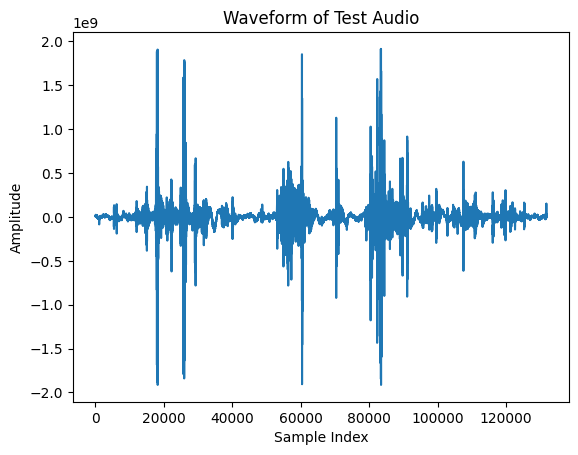

In [20]:
plt.figure()
plt.plot(data)
plt.xlabel("Sample Index")
plt.ylabel('Amplitude')
plt.title('Waveform of Test Audio')
plt.show()

Each audio sample in the dataset such as its filename, its class label, the ‘fold’ sub-folder location, and so on.

csv with two points:
relative_path / classID

In [39]:
path = os.getcwd() + "/clips_rd" 
food_categories = os.listdir(path) 
print("Files and directories in '", path, "' :")  
print(food_categories)

Files and directories in ' c:\Users\Snoop\OneDrive - University of Vermont\Documents\University of Vermont\Machine Learning\ML-audio-chef/clips_rd ' :
['aloe', 'burger', 'cabbage', 'candied_fruits', 'carrots', 'chips', 'chocolate', 'drinks', 'fries', 'grapes', 'gummies', 'ice-cream', 'jelly', 'noodles', 'pickles', 'pizza', 'ribs', 'salmon', 'soup', 'wings']


In [55]:
data = [['class', 'classID']]
for i, food in enumerate(food_categories):
    data.append([food, i+1])

# File path for the CSV file
csv_file_path = 'classID.csv'

# Open the file in write mode
with open(csv_file_path, mode='w', newline='') as file:
    # Create a csv.writer object
    writer = csv.writer(file)
    # Write data to the CSV file
    writer.writerows(data)

In [57]:
data = [['relative_path', 'classID', 'label']]
for i, food in enumerate(food_categories):
    path = os.getcwd() + "/clips_rd/" + food
    wavs = os.listdir(path)
    for wav in wavs:
        data.append([f"/clips_rd/{food}/{wav}",i+1, food])

print(data)

[['relative_path', 'classID', 'label'], ['/clips_rd/aloe/aloe_10_01.wav', 1, 'aloe'], ['/clips_rd/aloe/aloe_10_02.wav', 1, 'aloe'], ['/clips_rd/aloe/aloe_10_03.wav', 1, 'aloe'], ['/clips_rd/aloe/aloe_10_04.wav', 1, 'aloe'], ['/clips_rd/aloe/aloe_10_05.wav', 1, 'aloe'], ['/clips_rd/aloe/aloe_10_06.wav', 1, 'aloe'], ['/clips_rd/aloe/aloe_10_07.wav', 1, 'aloe'], ['/clips_rd/aloe/aloe_10_08.wav', 1, 'aloe'], ['/clips_rd/aloe/aloe_10_09.wav', 1, 'aloe'], ['/clips_rd/aloe/aloe_10_10.wav', 1, 'aloe'], ['/clips_rd/aloe/aloe_10_11.wav', 1, 'aloe'], ['/clips_rd/aloe/aloe_10_12.wav', 1, 'aloe'], ['/clips_rd/aloe/aloe_10_13.wav', 1, 'aloe'], ['/clips_rd/aloe/aloe_10_14.wav', 1, 'aloe'], ['/clips_rd/aloe/aloe_10_15.wav', 1, 'aloe'], ['/clips_rd/aloe/aloe_10_16.wav', 1, 'aloe'], ['/clips_rd/aloe/aloe_10_17.wav', 1, 'aloe'], ['/clips_rd/aloe/aloe_10_18.wav', 1, 'aloe'], ['/clips_rd/aloe/aloe_10_19.wav', 1, 'aloe'], ['/clips_rd/aloe/aloe_10_20.wav', 1, 'aloe'], ['/clips_rd/aloe/aloe_10_21.wav', 1, 'al

In [58]:
# File path for the CSV file
csv_file_path = 'metadeta.csv'

# Open the file in write mode
with open(csv_file_path, mode='w', newline='') as file:
    # Create a csv.writer object
    writer = csv.writer(file)
    # Write data to the CSV file
    writer.writerows(data)

## Tranforming Data / Audio Files

Transforming data so that tat its in a format the model expects. Can be done during runtime. 

Audio files tend to be large- so we're keeping only the audio file names in our taining data.

Then at run time, as we train the model we'll load the audio data for that bath and then process it.So we keep audiodata for only one batch in memory at a time.

Tranforms:
- Load Audio file
- Resample and convert to stereo
    - check the channel sizes of our files- some could be mono- others could be 2 or more :/
- resize to fixed length so all the audios are the same length
- audio augmentation tiime shift
- convert  to mel spectogram
- spectogram augmentation. SPECAUGMENTATING TIME!!

Potential audio processing libraries:
- librosa
    - slower that pytorch
    - seems to be used for smaller datasets?
    - usually used for making spectograms- but since pytorch came out with torchaudio it isn't used as much by new learners- usually used by people who are used to the library. 
- pytorch (torchaudio)
    - pretty fast
    - may be better for such a large data set
    - well documented (in my opinion)
    - we'll be using pytorch anyway to processed the spectrogram- so we probably shuld just use torchaudio??
- audio flux
    - super fast allegedly
    - fairly new

In [ ]:
import math, random
import torch
import torchaudio
from torchaudio import transforms

